# AI vs Human Text Detector using NLP

## Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

## Data Discovery

### Loading Data

In [17]:
# Load the data "AI_Human.csv"
df = pd.read_csv("AI_Human.csv")

### Data Description

In [18]:
# Display the first few rows of the dataset
print(df.head())

                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0


In [19]:
# Get a concise summary of the dataframe
print(df.info())

# Get summary statistics for numerical columns
print(df.describe())

# For categorical data, you can use value_counts() to see distribution of categories
print(df['text'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB
None
           generated
count  487235.000000
mean        0.372383
std         0.483440
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of

### Looking at missing values

In [20]:
# Check for missing values
print(df.isnull().sum())

text         0
generated    0
dtype: int64


### Checking for duplicates

In [21]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


### Creating a new column for the length of the text and analyzing it

In [22]:
# Add a new column for text length
df['text_length'] = df['text'].apply(len)

# Basic statistics on text length
print(df['text_length'].describe())

count    487235.000000
mean       2269.586592
std         988.814028
min           1.000000
25%        1583.000000
50%        2102.000000
75%        2724.000000
max       18322.000000
Name: text_length, dtype: float64


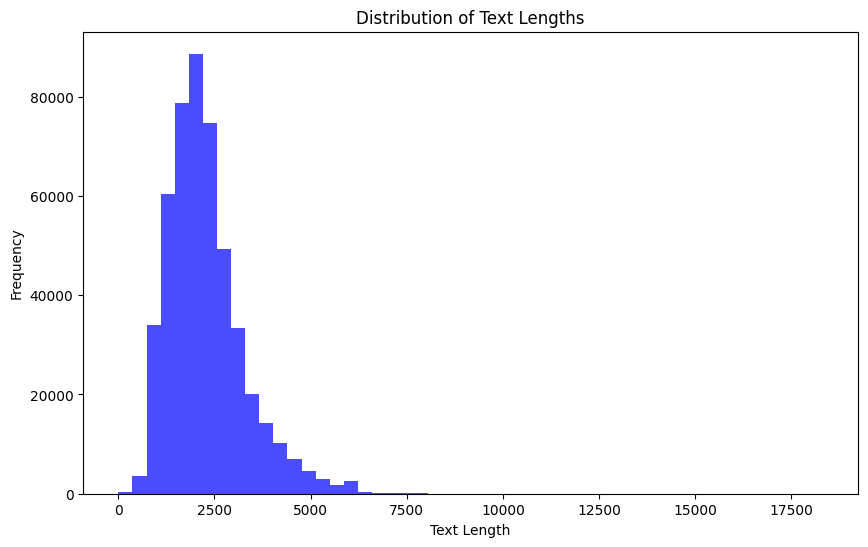

In [23]:
# Plotting the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

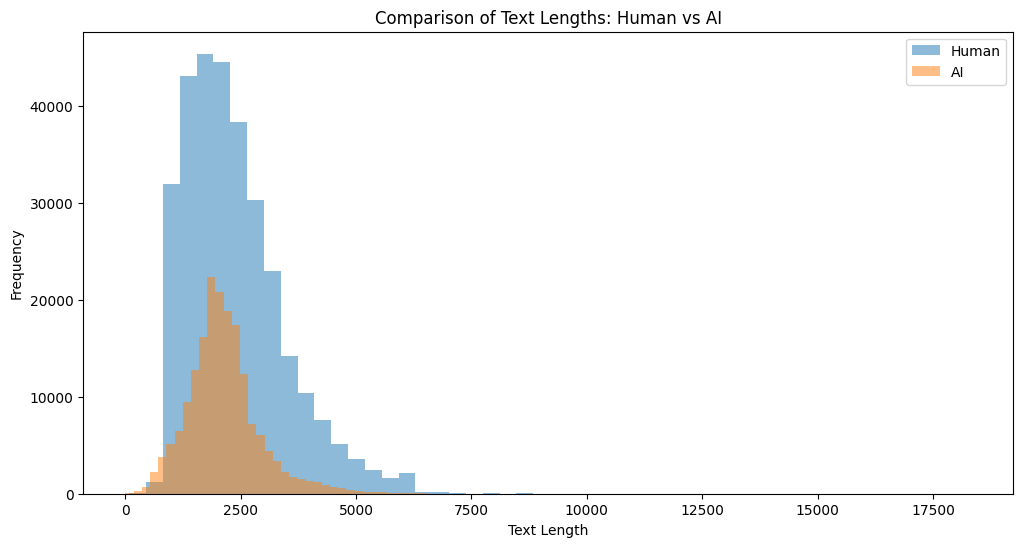

In [24]:
# Filter the dataset into two groups
ai_texts = df[df['generated'] == 1]['text_length']
human_texts = df[df['generated'] == 0]['text_length']

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(human_texts, bins=50, alpha=0.5, label='Human')
plt.hist(ai_texts, bins=50, alpha=0.5, label='AI')
plt.title('Comparison of Text Lengths: Human vs AI')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Looking at the distribution of Ai and Human text

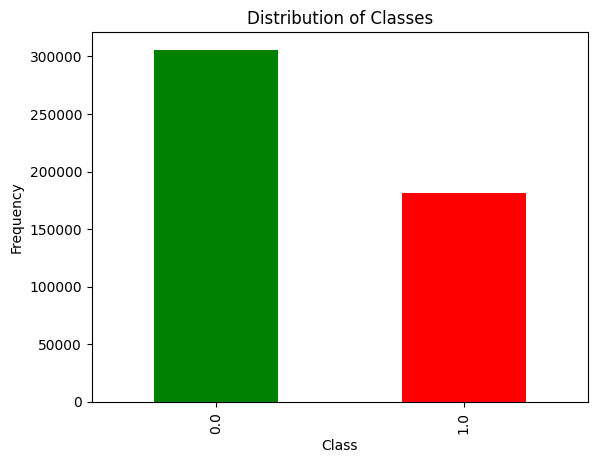

In [25]:
# Plotting the distribution of classes
df['generated'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Looking at outliers

<Figure size 800x600 with 0 Axes>

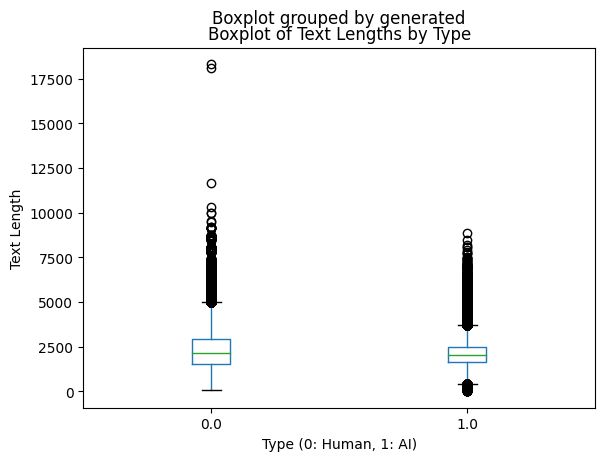

In [26]:
plt.figure(figsize=(8, 6))
df.boxplot(by='generated', column=['text_length'], grid=False)
plt.title('Boxplot of Text Lengths by Type')
plt.xlabel('Type (0: Human, 1: AI)')
plt.ylabel('Text Length')
plt.show()

## Data Preprocessing

### Removing the outliers from the dataset using IQR

In [27]:
# checking for outliers
q1 = df['text_length'].quantile(0.25)
q3 = df['text_length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
# remove outliers
df_no_outliers = df[(df['text_length'] > lower_bound) & (df['text_length'] < upper_bound)]

### Undersampling the human generated text to balance the dataset

In [28]:
# Separate the dataset into human and AI-generated texts
df_human = df_no_outliers[df_no_outliers['generated'] == 0]
df_ai = df_no_outliers[df_no_outliers['generated'] == 1]

# Undersample the human-generated texts
df_human_undersampled = resample(df_human, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_ai),     # to match minority class
                                 random_state=123) # reproducible results

# Combine the undersampled human-generated texts with AI-generated texts
df_balanced = pd.concat([df_human_undersampled, df_ai])

# Shuffle the dataset to mix the order of rows
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

#### Making sure the distribution of the data is balanced 

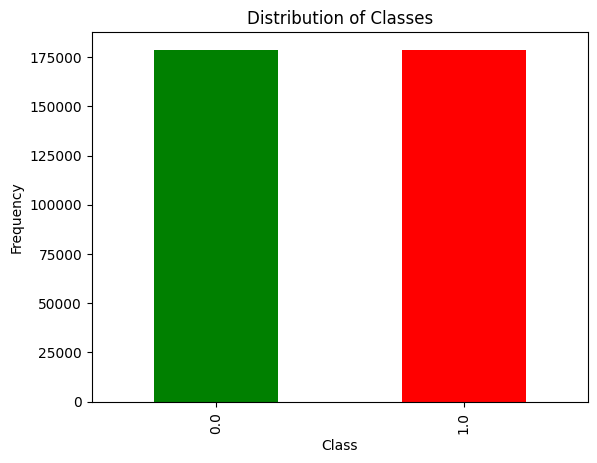

In [29]:
# Plotting the distribution of classes
df_balanced['generated'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Cleaning the text

In [30]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning function to the dataset
df_balanced['clean_text'] = df_balanced['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Seeing the difference before and after cleaning the text

In [31]:
# describe the cleaned text
print(df_balanced['clean_text'].describe())
# Display the first few rows of the dataset
print(df_balanced.head())
# Get a concise summary of the dataframe
print(df_balanced.info())
# see clean text column 
print(df_balanced['clean_text'].head())

count                                                357426
unique                                               340999
top       dear florida senator citizen believe electoral...
freq                                                      6
Name: clean_text, dtype: object
                                                text  generated  text_length  \
0  The use of this technology to red the emotiona...        0.0         2151   
1  Do we need a Facial Action Coding System in ou...        0.0         1074   
2  While distance learning offers flexibility and...        1.0         1864   
3  Dear TEACHER_NAME,\n\nI think that u must have...        0.0         1795   
4  Consider this, instead of driving to work ever...        0.0         1972   

                                          clean_text  
0  use technology red emotional expressions stude...  
1  need facial action coding system classrooms ag...  
2  distance learning offers flexibility convenien...  
3  dear teachername think u

## Model Building

### Splitting the data into training and testing and tokenizing the text

In [32]:
# Split the data
X = df_balanced['clean_text']
y = df_balanced['generated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

### Using glove embeddings to convert the text into vectors

In [3]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

glove_path = 'glove.6B.100d.txt'  
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word_index, embedding_dim)



### Buliding the our own squential model

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

def create_model_with_glove(embedding_matrix, input_length=100):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], 
                  output_dim=embedding_matrix.shape[1], 
                  weights=[embedding_matrix], 
                  input_length=input_length, 
                  trainable=False),
        LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model_with_glove(embedding_matrix, input_length=100)

### Visualizing the model summary

In [36]:
# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          21692000  
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 21722251 (82.86 MB)
Trainable params: 30251 (118.17 KB)
Non-trainable params: 21692000 (82.75 MB)
_________________________________________________________________
None


### Training the model

In [37]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5


4022/4022 [==============================] - 217s 53ms/step - loss: 0.1570 - accuracy: 0.9402 - val_loss: 0.0788 - val_accuracy: 0.9722
Epoch 2/5
4022/4022 [==============================] - 214s 53ms/step - loss: 0.0747 - accuracy: 0.9731 - val_loss: 0.0609 - val_accuracy: 0.9790
Epoch 3/5
4022/4022 [==============================] - 213s 53ms/step - loss: 0.0543 - accuracy: 0.9806 - val_loss: 0.0374 - val_accuracy: 0.9869
Epoch 4/5
4022/4022 [==============================] - 211s 52ms/step - loss: 0.0441 - accuracy: 0.9844 - val_loss: 0.0355 - val_accuracy: 0.9878
Epoch 5/5
4022/4022 [==============================] - 212s 53ms/step - loss: 0.0374 - accuracy: 0.9870 - val_loss: 0.0295 - val_accuracy: 0.9896


### Testing the model

In [38]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

2234/2234 [==============================] - 17s 8ms/step - loss: 0.0287 - accuracy: 0.9900
Test Accuracy: 0.9900400042533875
Test Loss: 0.02874090149998665


# AI vs Human Text Detector Application

## Function to detect if the text is AI or Human generated

In [39]:
def predict_text(text):
    # Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=100)
    
    # Predict
    prediction = model.predict(padded)
    
    # Assuming your model outputs probabilities for being AI-generated
    # Adjust based on your model's output
    ai_probability = prediction[0][0]
    
    return ai_probability

## Application

In [40]:
import sys
from PyQt5.QtWidgets import QApplication, QWidget, QTextEdit, QPushButton, QVBoxLayout, QLabel
from PyQt5.QtCore import Qt


def analyze_text():
    user_input = text_edit.toPlainText()
    if user_input.strip():  # Check if input is not just whitespace
        confidence = predict_text(user_input) * 100
        result_label.setText(f"The text is {confidence:.2f}% AI-generated.")
    else:
        result_label.setText("Please enter some text to analyze.")

def terminate_application():
    app.quit()

app = QApplication(sys.argv)
window = QWidget()
window.setWindowTitle('AI Text Detector')
window.setGeometry(100, 100, 600, 400)  # x, y, width, height

layout = QVBoxLayout()

text_edit = QTextEdit()
layout.addWidget(text_edit)

process_button = QPushButton('Process Text')
process_button.clicked.connect(analyze_text)
layout.addWidget(process_button)

result_label = QLabel('Result will be shown here.')
layout.addWidget(result_label)

terminate_button = QPushButton('Terminate')
terminate_button.setStyleSheet("QPushButton {background-color: red; color: white; font-weight: bold;}")
terminate_button.clicked.connect(terminate_application)
layout.addWidget(terminate_button)

window.setLayout(layout)
window.show()

sys.exit(app.exec_())


1/1 [==============================] - 0s 22ms/step


SystemExit: 0

C:\Users\bachi\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


: 